
### Lung Diseases 

<br>


A team of researchers from Qatar University, Doha, Qatar, and the University of Dhaka, Bangladesh along with their collaborators from Pakistan and Malaysia in collaboration with medical doctors have created a database of chest X-ray images for COVID-19 positive cases along with Normal and Viral Pneumonia images. In our current release, there are 1200 COVID-19 positive images, 1341 normal images, and 1345 viral pneumonia images. We will continue to update this database as soon as we have new x-ray images for COVID-19 pneumonia patients.



<br>
<hr>

In [1]:
import os 
import glob 
import time
import cv2 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from google.colab.patches import cv2_imshow


import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Resnet
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
# set seed 
seed = 42 
np.random.seed(seed)
tf.random.set_seed(seed=seed)

In [3]:
# GPU check 
if tf.test.gpu_device_name():
    print('Default GPU device: {}'.format(tf.test.gpu_device_name()))
else: 
    print('Please install GPU for tensorflow')

Default GPU device: /device:GPU:0


In [4]:
# class names 
class_names =  ['COVID', 'NORMAL', 'Viral_Pneumonia']
for i in range(len(class_names)):
    print(class_names[i] ,":" , i)

COVID : 0
NORMAL : 1
Viral_Pneumonia : 2


In [5]:
# image dimension

img = cv2.imread('/content/drive/MyDrive/Deep_Learning_Projetos/case_visao_computacional/lung_diseases/inferencia/COVID.png', cv2.IMREAD_UNCHANGED)
 
dimensions = img.shape

height = img.shape[0]
width = img.shape[1]

 
print('Image Dimension    : ',dimensions)
print('Image Height       : ',height)
print('Image Width        : ',width)

Image Dimension    :  (256, 256)
Image Height       :  256
Image Width        :  256


In [6]:
# Load dataset 

data_path = "/content/drive/MyDrive/Deep_Learning_Projetos/case_visao_computacional/images"


train_dataset = image_dataset_from_directory(directory=data_path,
                                              labels="inferred",
                                              label_mode="int",
                                              class_names=class_names,
                                              color_mode="rgb",
                                              batch_size=32,
                                              image_size=(224, 224),
                                              shuffle=True,
                                              seed=42,
                                              validation_split=0.20,
                                              subset="training",
                                              interpolation="bilinear",
                                              follow_links=False
                                          )



test_dataset = image_dataset_from_directory(directory=data_path,
                                              labels="inferred",
                                              label_mode="int",
                                              class_names=class_names,
                                              color_mode="rgb",
                                              batch_size=32,
                                              image_size=(224, 224),
                                              shuffle=True,
                                              seed=42,
                                              validation_split=0.20,
                                              subset="validation",
                                              interpolation="bilinear",
                                              follow_links=False)


Found 3882 files belonging to 3 classes.
Using 3106 files for training.
Found 3882 files belonging to 3 classes.
Using 776 files for validation.


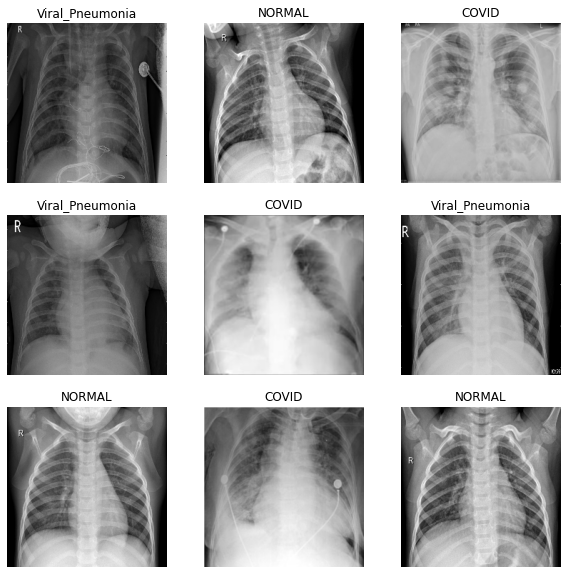

In [7]:
# samples 

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

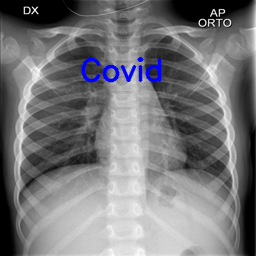

In [8]:
path = '/content/drive/MyDrive/Deep_Learning_Projetos/case_visao_computacional/lung_diseases/inferencia/COVID.png'
img = cv2.imread(path)

font=cv2.FONT_HERSHEY_SIMPLEX 
org=(80,80) 
fontScale=1
color=(255, 0, 0) 
thickness=2 
image = cv2.putText(img, 'Covid', org, font, fontScale, color, thickness, cv2.LINE_AA) 

cv2_imshow(image)  

<br>
<hr>
<br>
<br>

#### Convolutional Neural network 

<br>

In [9]:
# normalize pixels 
normalization_layer = Rescaling(1./255)

normalized_dataset = train_dataset.map(lambda x, y: (preprocess_input(x), y))
image_batch, labels_batch = next(iter(normalized_dataset))
first_image = image_batch[0]

# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


-123.68 151.061


In [10]:
# ResNet50 architecture 
resnet = ResNet50(include_top=False, input_shape=(224,224,3), classes=2)

In [11]:
# freeze layers
for layers in resnet.layers:
    layers.trainable=False

In [12]:
# Resnet50 with fine-tuning 

image = resnet.input
image = preprocess_input(image) # preprocessing image 
input = resnet.output
x = GlobalAveragePooling2D(name="avg_pool")(input)
output_layer = Dense(3, activation="softmax", name="predictions")(x)


model = Model(inputs=resnet.input, outputs=output_layer)

In [13]:
# config network 
model.compile(optimizer=Adam(lr=0.001),
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


early = EarlyStopping(monitor='val_loss',patience=5)

In [14]:
history = model.fit(train_dataset,  # normalizing images during train
          epochs=15,
          validation_data=test_dataset,
          callbacks=[early])

Epoch 1/15
98/98 [==============================] - 757s 8s/step - loss: 0.4601 - accuracy: 0.8180 - val_loss: 0.1224 - val_accuracy: 0.9588
Epoch 2/15
98/98 [==============================] - 57s 555ms/step - loss: 0.1162 - accuracy: 0.9580 - val_loss: 0.1025 - val_accuracy: 0.9601
Epoch 3/15
98/98 [==============================] - 57s 556ms/step - loss: 0.0908 - accuracy: 0.9695 - val_loss: 0.0828 - val_accuracy: 0.9691
Epoch 4/15
98/98 [==============================] - 57s 556ms/step - loss: 0.0787 - accuracy: 0.9698 - val_loss: 0.0810 - val_accuracy: 0.9665
Epoch 5/15
98/98 [==============================] - 57s 555ms/step - loss: 0.0658 - accuracy: 0.9788 - val_loss: 0.0751 - val_accuracy: 0.9704
Epoch 6/15
98/98 [==============================] - 57s 557ms/step - loss: 0.0622 - accuracy: 0.9788 - val_loss: 0.0685 - val_accuracy: 0.9704
Epoch 7/15
98/98 [==============================] - 57s 556ms/step - loss: 0.0587 - accuracy: 0.9820 - val_loss: 0.0641 - val_accuracy: 0.9768
E

In [15]:
# save model 
!mkdir -p /content/drive/MyDrive/Deep_Learning_Projetos/case_visao_computacional/lung_diseases/saved_model_resnet
model.save('/content/drive/MyDrive/Deep_Learning_Projetos/case_visao_computacional/lung_diseases/saved_model_resnet/resnet_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Deep_Learning_Projetos/case_visao_computacional/lung_diseases/saved_model_resnet/resnet_model/assets


<br>
<hr>
<br>
<br>
<br>

<br>
<hr>
<br>
<br>


#### Evaluate model

<br>

In [16]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Deep_Learning_Projetos/case_visao_computacional/lung_diseases/saved_model_resnet/resnet_model')

In [17]:
loss, acc = new_model.evaluate(test_dataset)

25/25 [==============================] - 13s 352ms/step - loss: 0.0473 - accuracy: 0.9781


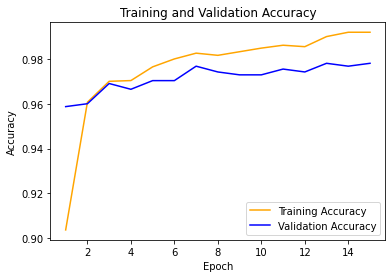

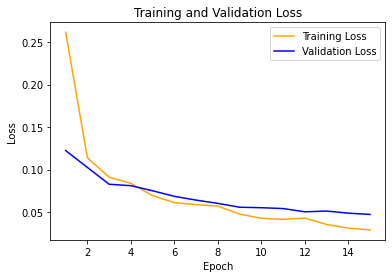

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='orange', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='orange', label='Training Loss')
plt.plot(epochs, val_loss, color='blue', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [19]:
#y_pred = new_model.predict(test_dataset)
#predicted_categories = tf.argmax(y_pred, axis=1)
#true_categories = tf.concat([y for x, y in test_dataset], axis=0)
#confusion_matrix(predicted_categories, true_categories)

In [20]:
#print(classification_report(true_categories, predicted_categories, target_names=class_names))

<br>
<hr>
<br>
<br>
<br>


### Inference 
<br>

In [21]:
# load model 
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Deep_Learning_Projetos/case_visao_computacional/lung_diseases/saved_model_resnet/resnet_model')

In [22]:
new_model.evaluate(test_dataset)

25/25 [==============================] - 13s 346ms/step - loss: 0.0473 - accuracy: 0.9781


[0.04725193232297897, 0.9780927896499634]

In [23]:
def inference(image_path):

    # preprocessing image 
    img = load_img(image_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # prediction 
    y_pred = new_model.predict(x)
    y_pred = np.argmax(y_pred, axis=1)



    if y_pred.any()==0:
      image = load_img(image_path)
      plt.figure(figsize=(8,5))
      plt.imshow(image)
      plt.title("Prediction: Covid-19")
      plt.show()
    elif y_pred.any()==1:
      image = load_img(image_path)
      plt.figure(figsize=(8,5))
      plt.imshow(image)
      plt.title("Prediction: Normal")
      plt.show()
    elif y_pred.any()==2:
      image = load_img(image_path)
      plt.figure(figsize=(8,5))
      plt.imshow(image)
      plt.title("Prediction: Pneumonia")
      plt.show()

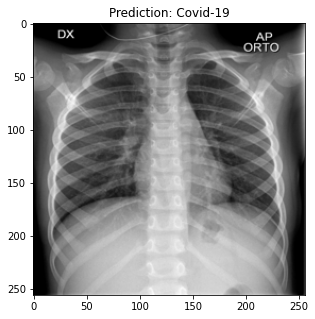

In [24]:
# covid class 
path = "/content/drive/MyDrive/Deep_Learning_Projetos/case_visao_computacional/lung_diseases/inferencia/COVID.png"
inference(path)

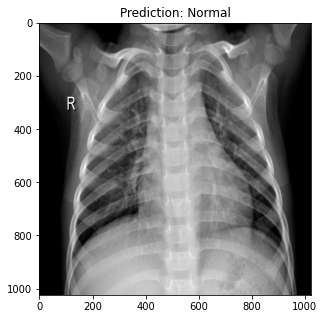

In [25]:
# normal class
path = "/content/drive/MyDrive/Deep_Learning_Projetos/case_visao_computacional/lung_diseases/inferencia/NORMAL.png"
inference(path)

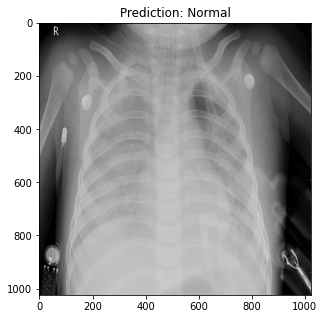

In [26]:
# pneumonia class (erro)
path = "/content/drive/MyDrive/Deep_Learning_Projetos/case_visao_computacional/lung_diseases/inferencia/Viral_Pneumonia.png"
inference(path)

<br>
<hr>
<br>
<br>

### GradCAM 

<br>

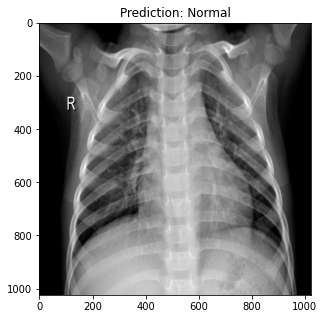

In [38]:
path = "/content/drive/MyDrive/Deep_Learning_Projetos/case_visao_computacional/lung_diseases/inferencia/NORMAL.png"
inference(path)

In [39]:
image = np.array(load_img(path, target_size=(224, 224, 3)))

In [40]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [41]:
# define layers 
last_conv_layer = new_model.get_layer("conv5_block3_out")
last_conv_layer_model = Model(new_model.inputs, last_conv_layer.output)

In [42]:
classifier_input = Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in ["avg_pool", "predictions"]:
    x = new_model.get_layer(layer_name)(x)
classifier_model = Model(classifier_input, x)

In [43]:
with tf.GradientTape() as tape:
    inputs = image[np.newaxis, ...]
    last_conv_layer_output = last_conv_layer_model(inputs)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [44]:
grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [45]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

In [46]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [47]:
# Average over all the filters to get a single 2D array
gradcam_2 = np.mean(last_conv_layer_output, axis=-1)
# Clip the values (equivalent to applying ReLU)
# and then normalise the values
gradcam_2 = np.clip(gradcam_2, 0, np.max(gradcam_2)) / np.max(gradcam_2)
gradcam_2 = cv2.resize(gradcam_2, (224, 224))

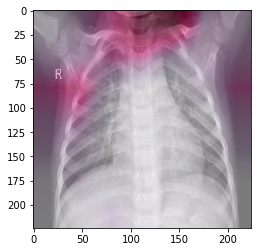

In [48]:
# Normal
plt.imshow(image)
plt.imshow(gradcam_2, alpha=0.5, cmap='PuRd') # Plasma

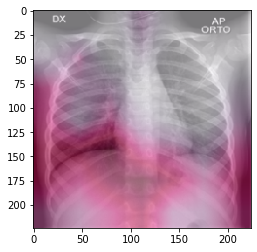

In [37]:
# covid 
plt.imshow(image)
plt.imshow(gradcam_1, alpha=0.5, cmap='PuRd')

In [49]:
gradcam_1==gradcam_2

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

<br>
<hr>
<br>